In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torchvision.models as models

from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
import kagglehub

# Free download
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ai-vs-human-generated-dataset


In [ ]:
# Set to a number to specify size of training data; should be an even number
# None = max training size
# TRAIN_SIZE = 500
TRAIN_SIZE = None

In [ ]:
!nvidia-smi

Sat Apr 12 05:23:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             51W /  350W |    5405MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available, using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU. Too bad!!")

CUDA is available, using GPU.


In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set fixed seed
set_seed(42)

In [ ]:
# ! pip install -q kaggle
# from google.colab import files
# files.upload()
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! chmod 600 /content/kaggle.json
# ! kaggle datasets list

In [ ]:
# Load the dataset
base_dir = path
train_df = pd.read_csv(path + "/train.csv")
test_df = pd.read_csv(path + "/test.csv")

# Display basic info
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

# Reduce size of train dataset for easier processing
if TRAIN_SIZE is not None and TRAIN_SIZE < train_df.shape[0]:
  train_df = train_df.loc[0:(TRAIN_SIZE - 1)]
  print("Train dataset shape after reduction:", train_df.shape)
train_df.head()
train_df.shape

Train dataset shape: (79950, 3)
Test dataset shape: (5540, 1)
Train dataset shape after reduction: (500, 3)


(500, 3)

In [ ]:
train_df = train_df.drop(columns=['Unnamed: 0'])
train_df.head()

,file_name,label
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [ ]:
# Add base directory to all file_name fields to make it easier to read each image
test_df['id'] = test_df['id'].apply(lambda x: os.path.join(base_dir, x))
train_df['file_name'] = train_df['file_name'].apply(lambda x: os.path.join(base_dir, x))

In [ ]:
test_df.head()

,id
0,/kaggle/input/ai-vs-human-generated-dataset/te...
1,/kaggle/input/ai-vs-human-generated-dataset/te...
2,/kaggle/input/ai-vs-human-generated-dataset/te...
3,/kaggle/input/ai-vs-human-generated-dataset/te...
4,/kaggle/input/ai-vs-human-generated-dataset/te...


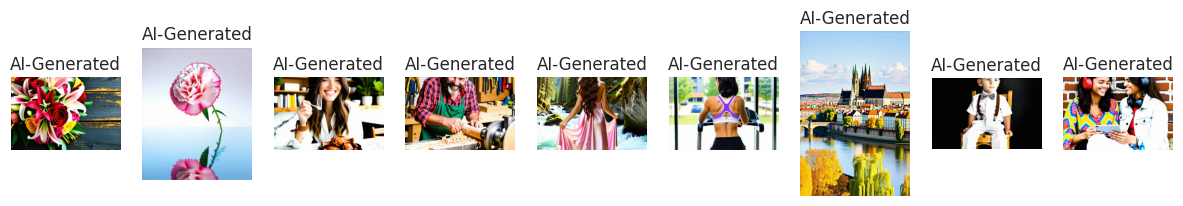

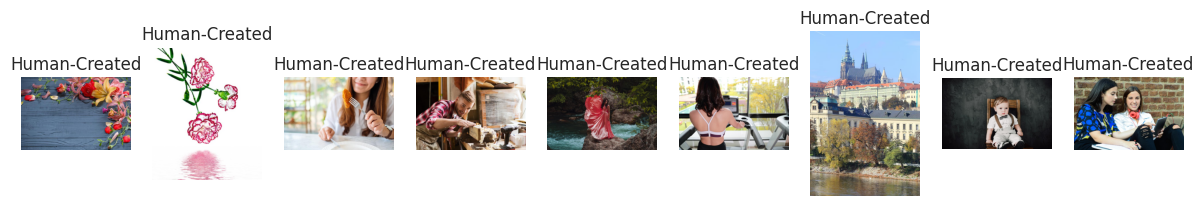

In [ ]:
# Function to display images
def show_images(df, label, num_images=9):
    sample_images = df[df["label"] == label].sample(num_images, random_state=15)["file_name"].values

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("AI-Generated" if label == 1 else "Human-Created")

    plt.show()

# Show AI-Generated Images
show_images(train_df, label=1)

# Show Human-Created Images
show_images(train_df, label=0)


First 5 rows of train.csv:
                                           file_name  label
0  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
1  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
2  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
3  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
4  /kaggle/input/ai-vs-human-generated-dataset/tr...      1


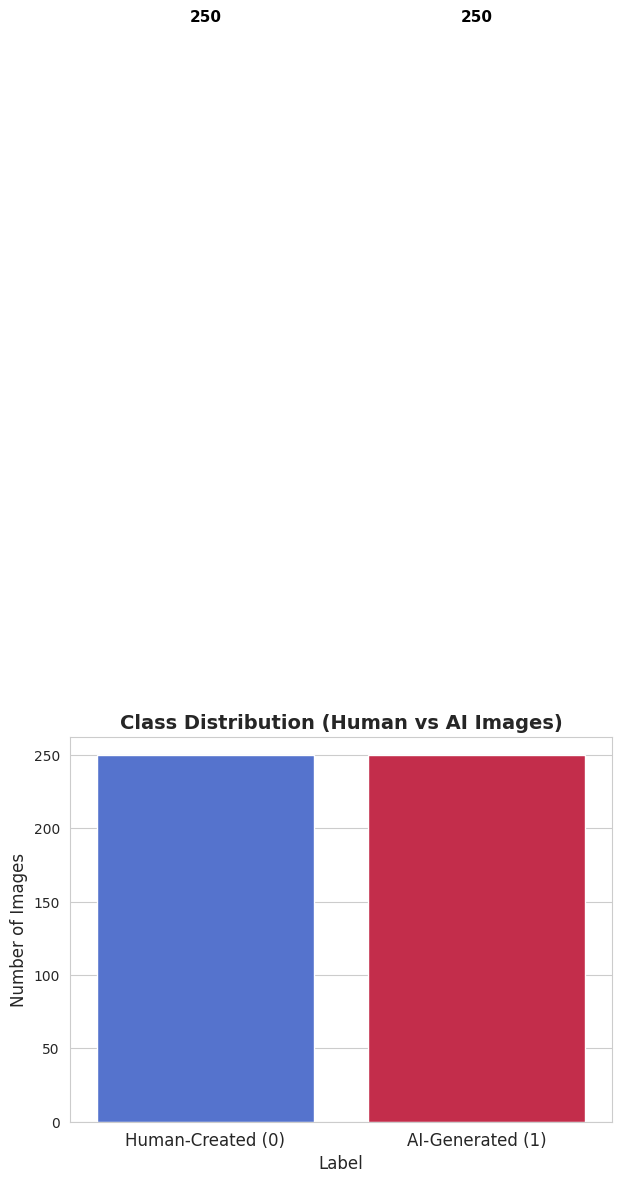

In [ ]:
# Modified from Victor's notebook
df = train_df

# Print the first few rows of train.csv
print("\nFirst 5 rows of train.csv:")
print(df.head())

# Extract only the filename (remove "train_data/" prefix)
# df["file_name"] = df["file_name"].apply(lambda x: os.path.basename(x))

# Construct full image path
# df["full_path"] = df["file_name"].apply(lambda x: os.path.join(DATASET_DIR, x))

# Convert label column to integer
df["label"] = df["label"].astype(int)

# Class Distribution
label_counts = df["label"].value_counts().sort_index()

# Plot Class Distribution
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")

ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=["royalblue", "crimson"])
plt.xticks(ticks=[0, 1], labels=["Human-Created (0)", "AI-Generated (1)"], fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xlabel("Label", fontsize=12)
plt.title("Class Distribution (Human vs AI Images)", fontsize=14, fontweight="bold")

# Add text labels on bars
for i, count in enumerate(label_counts.values):
    ax.text(i, count + 500, f"{count:,}", ha='center', fontsize=11, fontweight="bold", color="black")

plt.show()

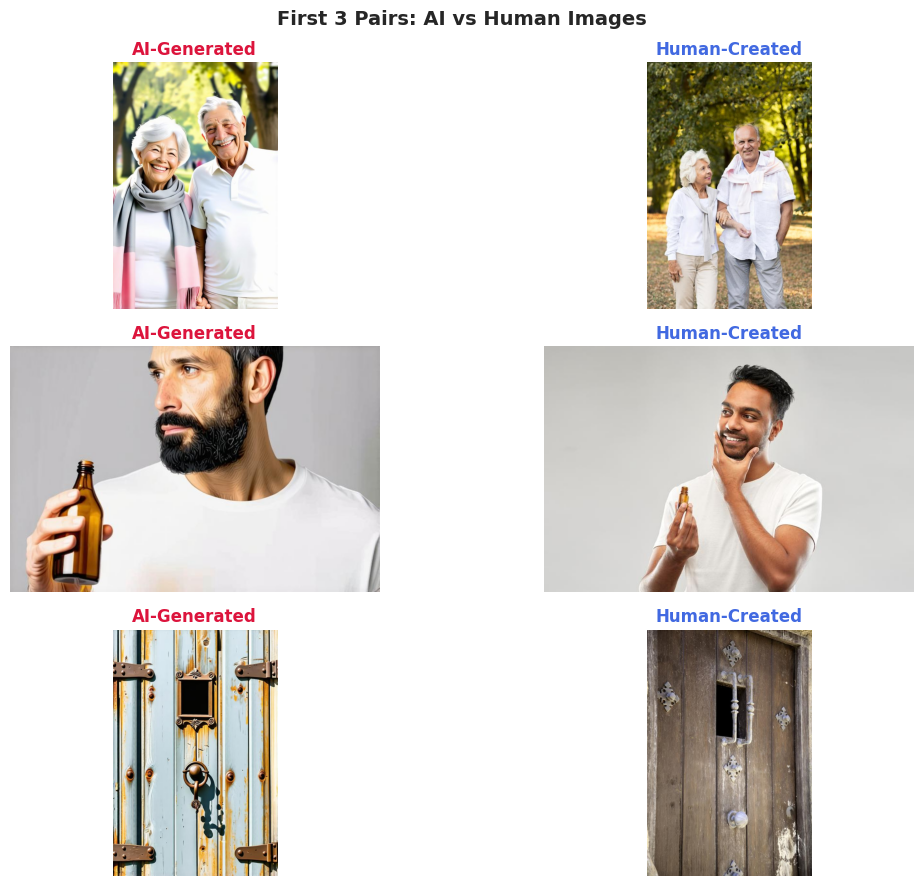

In [ ]:
# Display First 3 Pairs of AI vs Human Images
def show_paired_images():
    """
    Displays the first 3 pairs of images: each AI-generated image placed next to its corresponding human-created image.
    """
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows, 2 columns

    # Select first 3 AI-Human pairs
    ai_images = df[df["label"] == 1].head(3)["file_name"].values  # First 3 AI images (Label 1)
    human_images = df[df["label"] == 0].head(3)["file_name"].values  # First 3 Human images (Label 0)

    for i in range(3):
        ai_img = Image.open(ai_images[i])  # Load AI image
        human_img = Image.open(human_images[i])  # Load Human image

        # AI-generated image (Left)
        axes[i, 0].imshow(ai_img)
        axes[i, 0].axis("off")
        axes[i, 0].set_title("AI-Generated", fontsize=12, fontweight="bold", color="crimson")

        # Human-created image (Right)
        axes[i, 1].imshow(human_img)
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Human-Created", fontsize=12, fontweight="bold", color="royalblue")

    plt.suptitle("First 3 Pairs: AI vs Human Images", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

# Show the first 3 pairs of images
show_paired_images()

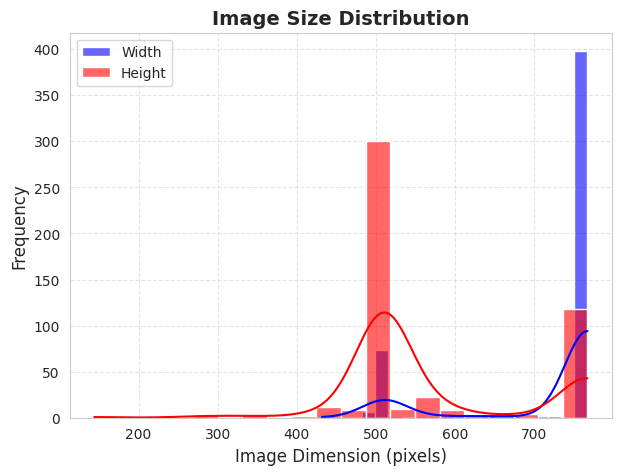

In [ ]:
# Image Size Distribution Plot
image_shapes = []

# Sample 500 images for efficiency
sampled_images = df["file_name"].sample(500, random_state=42)

for img_path in sampled_images:
    try:
        img = Image.open(img_path).convert("RGB")  # Ensure image is in RGB mode
        image_shapes.append(img.size)  # (width, height)
    except Exception as e:
        print(f"Error loading image: {img_path} | {e}")

# Convert to DataFrame for visualization
image_sizes_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])

# Plot image size distribution
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")

sns.histplot(image_sizes_df["Width"], bins=20, color="blue", label="Width", kde=True, alpha=0.6)
sns.histplot(image_sizes_df["Height"], bins=20, color="red", label="Height", kde=True, alpha=0.6)

plt.xlabel("Image Dimension (pixels)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Image Size Distribution", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)  # Add grid lines

plt.show()

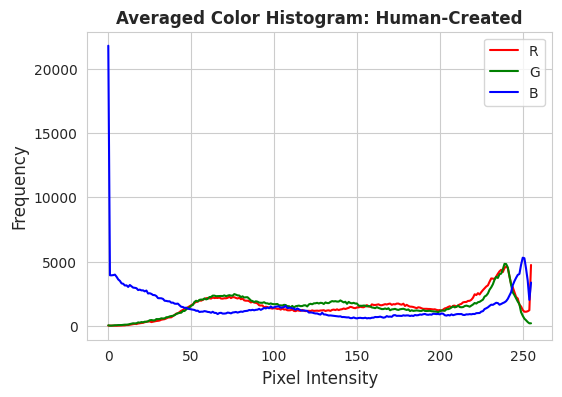

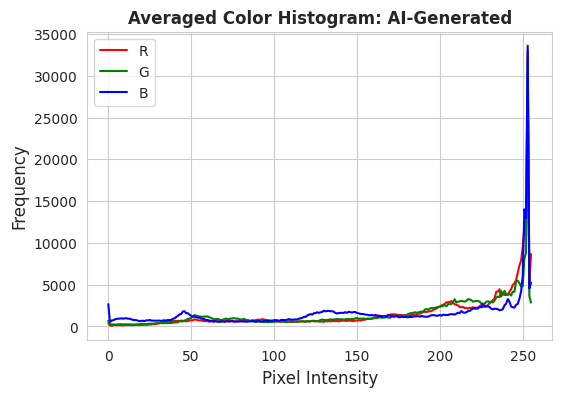

In [ ]:
# Color Histogram Visualization
def plot_color_histogram(image_path, title):
    """
    Plots RGB color histogram for a given image.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    colors = ("r", "g", "b")
    plt.figure(figsize=(6, 4))
    for i, col in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        sns.lineplot(x=np.arange(256), y=hist.flatten(), color=col, label=col.upper())

    plt.title(f"Averaged Color Histogram: {title}", fontsize=12, fontweight="bold")
    plt.xlabel("Pixel Intensity", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.show()

# Show color histogram of the first Human-created image (Label 0)
human_image_path = df[df["label"] == 0]["file_name"].iloc[0]  # Label 0 = Human
plot_color_histogram(human_image_path, "Human-Created")

# Show color histogram of the first AI-generated image (Label 1)
ai_image_path = df[df["label"] == 1]["file_name"].iloc[0]  # Label 1 = AI
plot_color_histogram(ai_image_path, "AI-Generated")

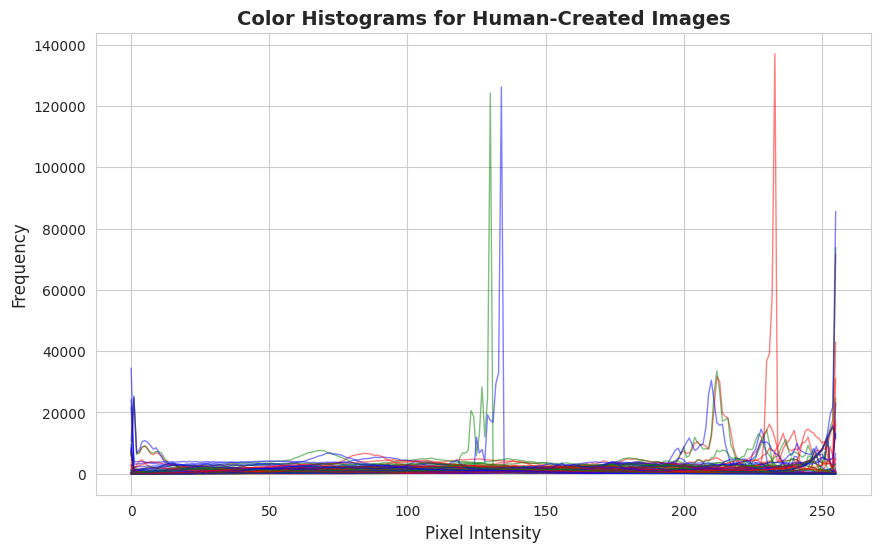

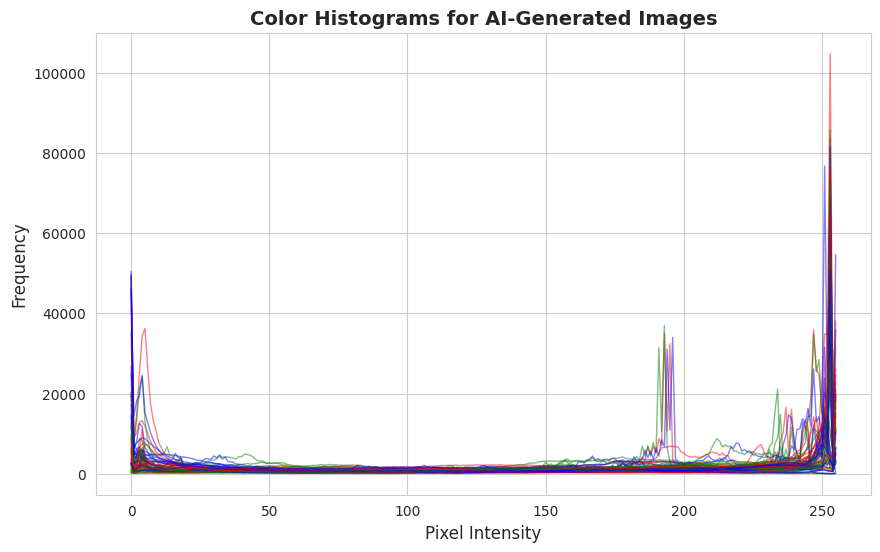

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#  Function to plot color histograms for multiple images (overlay each one)
def plot_overlayed_histograms(image_paths, title, color_labels=("r", "g", "b")):
    """
    Plots RGB color histograms for multiple images, overlaying each image’s histogram.
    """
    plt.figure(figsize=(10, 6))

    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot histogram for each image (overlayed)
        for i, col in enumerate(color_labels):
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            sns.lineplot(x=np.arange(256), y=hist.flatten(), color=col, alpha=0.5, linewidth=1)  # Lower alpha for visibility

    plt.title(f"Color Histograms for {title}", fontsize=14, fontweight="bold")
    plt.xlabel("Pixel Intensity", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.show()

# Select 20 AI-generated images and 20 Human-created images
num_samples = 20
human_image_paths = df[df["label"] == 0]["file_name"].iloc[:num_samples].tolist()  # Label 0 = Human
ai_image_paths = df[df["label"] == 1]["file_name"].iloc[:num_samples].tolist()  # Label 1 = AI

# Plot overlayed histograms for Human-created images
plot_overlayed_histograms(human_image_paths, "Human-Created Images")

# Plot overlayed histograms for AI-generated images
plot_overlayed_histograms(ai_image_paths, "AI-Generated Images")

In [ ]:
# Training Transformations (with Augmentation)
train_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Testing Transformations (NO Augmentation)
test_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

In [ ]:
# It's timm time
import timm
import torch.nn as nn
from pprint import pprint
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

model_names = timm.list_models(pretrained=True)
print(model_names)

['aimv2_1b_patch14_224.apple_pt', 'aimv2_1b_patch14_336.apple_pt', 'aimv2_1b_patch14_448.apple_pt', 'aimv2_3b_patch14_224.apple_pt', 'aimv2_3b_patch14_336.apple_pt', 'aimv2_3b_patch14_448.apple_pt', 'aimv2_huge_patch14_224.apple_pt', 'aimv2_huge_patch14_336.apple_pt', 'aimv2_huge_patch14_448.apple_pt', 'aimv2_large_patch14_224.apple_pt', 'aimv2_large_patch14_224.apple_pt_dist', 'aimv2_large_patch14_336.apple_pt', 'aimv2_large_patch14_336.apple_pt_dist', 'aimv2_large_patch14_448.apple_pt', 'bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k', 'beit_large_patch16_224.in22k_ft_in22k_in1k', 'beit_large_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_512.in22k_ft_in22k_in1k', 'beitv2_base_patch16_224.in1k_ft_in1k', 'beitv2_base_patch16_224.in1k_ft_in22k', 'beitv2_base_patch16_224.in1k_ft_in22k_in1k', 'beitv2_large_patch16_224.in1k_ft_in1k', 'b

Model card for convit_base.fb_in1k:
https://huggingface.co/timm/convit_base.fb_in1k/blame/c93eea8ccd421f7e9a7baa1a8357b15ad7246ec5/README.md

It's a ConViT model trained on the ImageNet-1k dataset.
https://arxiv.org/abs/2103.10697

In [ ]:
import json
from itertools import product

class CustomDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        self.df = pd.DataFrame(df)
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # img_path = self.df.iloc[idx]["file_name"]
        img_path = self.df.iloc[idx]['id' if self.is_test else 'file_name']
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            # img = self.transform(img)
            img = self.transform(img)

        if self.is_test:
          # 0 is a dummy value to make unpacking easier
            return img, 0
        else:
            label = self.df.iloc[idx]["label"]
            return img, label

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = ['efficientnetv2_rw_s.ra2_in1k', 'swin_tiny_patch4_window7_224.ms_in1k', 'convit_base.fb_in1k']
lrs = [1e-4, 1e-5]
schedulers = ['cosine', 'step', 'plateau']
epochs = 5
patience = 2
epochs_without_improvement = 0
best_val_loss = float('inf')
pos_weight = 0.4

results = {}
overall_best_f1 = 0.0
overall_best_config = None

def setup_params(model, lr, sched):
    global optimizer, criterion, scheduler  # so `train()` can access them

    pw = torch.tensor([pos_weight]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pw)

    # Get classifier or head parameters
    if hasattr(model, 'head'):
        head_params = list(model.head.parameters())
        other_params = [p for n, p in model.named_parameters() if "head" not in n]
    elif hasattr(model, 'classifier'):
        head_params = list(model.classifier.parameters())
        other_params = [p for n, p in model.named_parameters() if "classifier" not in n]
    else:
        raise ValueError("Model has neither 'head' nor 'classifier'")

    # Remove duplicates (sometimes they still overlap due to name mapping)
    head_ids = {id(p) for p in head_params}
    other_params = [p for p in model.parameters() if id(p) not in head_ids]

    optimizer = optim.AdamW([
        {"params": head_params, "lr": lr},
        {"params": other_params, "lr": lr}
    ], weight_decay=1e-2)

    scheduler = get_scheduler(optimizer, sched)
    criterion = criterion.to(device)

    print("AdamW Optimizer & Scheduler initialized")

def load_data(model):
    global train_loader, val_loader

    config = resolve_data_config({}, model=model, use_test_size=True)
    image_size = config['input_size'][-1]  # Usually (3, H, W), we take H/W
    transform = create_transform(**config)

    print("Expected input size:", config['input_size'])  # Add debug line

    # Override transform to be explicit and safe
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=config['mean'],
            std=config['std']
        )
    ])

    train_dataset = CustomDataset(train_df, transform)
    val_dataset = CustomDataset(val_df, transform)  # Make sure is_test is False to read actual labels.

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    model.eval()
    with torch.no_grad():
        for data, _ in train_loader:
            data = data.to(device)
            print(f"Image shape after transform: {data.shape}")
            output = model(data)  # this is where it would fail
            print("Model Output Shape:", output.shape)
            break

def get_scheduler(optimizer, name):
    if name == 'cosine':
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    elif name == 'step':
        return torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    elif name == 'plateau':
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    else:
        return None



def train(model):
    global overall_best_f1, overall_best_config

    # Initialize lists to store loss, accuracy, and F1 scores
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_f1s = []

    best_f1 = 0.0
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # Train the model
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        for data, label in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            data, label = data.to(device), label.to(device).float()  # Convert label to float

            optimizer.zero_grad()
            output = model(data).squeeze(1)  # Forward pass (squeeze to remove extra dim)
            loss = criterion(output, label)  # Compute loss
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            sigmoids = torch.sigmoid(output)
            preds = (sigmoids > 0.5).float()  # Convert logits to binary (0 or 1)
            acc = (preds == label).float().mean().item()  # Compute accuracy
            epoch_accuracy += acc
        print(f"Mean prediction:{sigmoids.mean()}")
        # print("Unique values in predictions:", np.unique(preds)) # error
        # print("Unique values in labels:", np.unique(val_labels_list))

        epoch_loss /= len(train_loader)
        epoch_accuracy /= len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # -- Validation --
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_pred_classes = []
        val_labels_list = []

        with torch.no_grad():
            for data, label in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
                data, label = data.to(device), label.to(device).float()
                output = model(data).squeeze(1)
                loss = criterion(output, label)
                val_loss += loss.item()
                sigmoids = torch.sigmoid(output)
                preds = (sigmoids > 0.5).float()  # still a float tensor of 0.0 and 1.0
                acc = (preds == label).float().mean().item()
                val_acc += acc

                # Convert to numpy arrays and then to int
                preds_np = preds.cpu().numpy().astype(int)
                labels_np = label.cpu().numpy().astype(int)

                val_pred_classes.extend(preds_np)
                val_labels_list.extend(labels_np)
            print(f"Mean prediction:{sigmoids.mean()}")
            print("Unique values in predictions:", np.unique(val_pred_classes))
            print("Unique values in labels:", np.unique(val_labels_list))


        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        # Calculate F1 Score
        val_f1 = f1_score(val_labels_list, val_pred_classes)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        # Print progress
        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}"
        )


        # Early Stopping Logic
        # Check improvement
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_val_loss = val_loss
            epochs_without_improvement = 0

            config_tag = f"{model_name}_lr{lr}_sched-{sched}"
            torch.save(model.state_dict(), f"best_weights_{config_tag}.pth")
            torch.save(model, f"best_model_{config_tag}.pt")
            print(f"Model saved with best F1: {best_f1:.4f}")
        else:
            epochs_without_improvement += 1
            print(f"No improvement at epoch {epoch+1}")

        if sched == 'plateau':
            scheduler.step(val_loss)
        else:
            scheduler.step()
        if epochs_without_improvement >= patience:
            print(f"Stopped early at epoch {epoch+1}")
            break
        model.eval()

    # Save results
    config_key = f"{model_name}_lr{lr}_sched-{sched}"
    results[config_key] = {
        "best_f1": best_f1,
        "lr": lr,
        "scheduler": sched,
        "model": model_name
    }

    if best_f1 > overall_best_f1:
        overall_best_f1 = best_f1
        overall_best_config = config_key


    with open("model_f1_results.json", "w") as f:
        json.dump(results, f, indent=4)

    print(f"\n Best config so far: {overall_best_config} with F1 = {overall_best_f1:.4f}")


def has_pretrained_weights(model_name):
    pretrained_cfg = timm.models.get_pretrained_cfg(model_name)
    return pretrained_cfg is not None

# MAIN PIPELINE LOOP
for model_name, lr, sched in product(models, lrs, schedulers):
    print(f"Training {model_name} with LR={lr} and Scheduler={sched}")
    if has_pretrained_weights(model_name):
        print(f"Loading pretrained weights for {model_name}")
        model = timm.create_model(model_name, pretrained=True, num_classes=1)
    else:
        print(f"No pretrained weights found for {model_name}")
        model = timm.create_model(model_name, pretrained=False, num_classes=1)

    print(model.default_cfg['input_size'])

    # Modify the classifier layer for binary classification
    # if hasattr(model, 'classifier'):
    #     model.classifier = nn.Linear(model.classifier.in_features, 1)
    # elif hasattr(model, 'head'):
    #     model.head = nn.Linear(model.head.in_features, 1)
    # else:
    #     raise ValueError("Model architecture is no good")
    model = model.to(device)

    load_data(model)

    setup_params(model, lr, sched)


    train(model)
print(f"\n Best overall config: {overall_best_config} with F1 = {overall_best_f1:.4f}")
torch.cuda.empty_cache()

Training efficientnetv2_rw_s.ra2_in1k with LR=0.001 and Scheduler=cosine
Loading pretrained weights for efficientnetv2_rw_s.ra2_in1k
(3, 288, 288)
Expected input size: (3, 384, 384)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 384, 384])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


Mean prediction:0.45309585332870483


Validation Epoch 1: 100%|██████████| 13/13 [00:01<00:00, 10.60it/s]


Mean prediction:0.25011172890663147
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.9297 | Train Acc: 0.7300 | Val Loss: 0.9828 | Val Acc: 0.8462 | Val F1: 0.8515
Model saved with best F1: 0.8515


Training Epoch 2: 100%|██████████| 50/50 [00:07<00:00,  6.52it/s]


Mean prediction:0.3846939504146576


Validation Epoch 2: 100%|██████████| 13/13 [00:01<00:00, 10.76it/s]


Mean prediction:0.18196961283683777
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.3489 | Train Acc: 0.8525 | Val Loss: 0.1942 | Val Acc: 0.8942 | Val F1: 0.9038
Model saved with best F1: 0.9038


Training Epoch 3: 100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


Mean prediction:0.21168768405914307


Validation Epoch 3: 100%|██████████| 13/13 [00:01<00:00, 10.39it/s]


Mean prediction:0.011376895010471344
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [3/5] Train Loss: 0.0950 | Train Acc: 0.9375 | Val Loss: 0.1026 | Val Acc: 0.9423 | Val F1: 0.9400
Model saved with best F1: 0.9400


Training Epoch 4: 100%|██████████| 50/50 [00:07<00:00,  6.47it/s]


Mean prediction:0.6240518093109131


Validation Epoch 4: 100%|██████████| 13/13 [00:01<00:00, 11.04it/s]


Mean prediction:0.5026308298110962
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [4/5] Train Loss: 0.1609 | Train Acc: 0.9250 | Val Loss: 1.2308 | Val Acc: 0.8462 | Val F1: 0.8727
No improvement at epoch 4


Training Epoch 5: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s]


Mean prediction:0.6581999063491821


Validation Epoch 5: 100%|██████████| 13/13 [00:01<00:00, 10.59it/s]


Mean prediction:0.010424487292766571
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [5/5] Train Loss: 0.1052 | Train Acc: 0.9425 | Val Loss: 0.0691 | Val Acc: 0.9327 | Val F1: 0.9263
No improvement at epoch 5
Stopped early at epoch 5

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-cosine with F1 = 0.9400
Training efficientnetv2_rw_s.ra2_in1k with LR=0.001 and Scheduler=step
Loading pretrained weights for efficientnetv2_rw_s.ra2_in1k
(3, 288, 288)
Expected input size: (3, 384, 384)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 384, 384])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:07<00:00,  6.43it/s]


Mean prediction:0.3778911828994751


Validation Epoch 1: 100%|██████████| 13/13 [00:01<00:00, 11.21it/s]


Mean prediction:0.2122291922569275
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.8572 | Train Acc: 0.7725 | Val Loss: 0.7669 | Val Acc: 0.8269 | Val F1: 0.8283
Model saved with best F1: 0.8283


Training Epoch 2: 100%|██████████| 50/50 [00:07<00:00,  6.43it/s]


Mean prediction:0.6040641069412231


Validation Epoch 2: 100%|██████████| 13/13 [00:01<00:00, 11.22it/s]


Mean prediction:0.12568843364715576
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.3053 | Train Acc: 0.8500 | Val Loss: 0.2359 | Val Acc: 0.9135 | Val F1: 0.9109
Model saved with best F1: 0.9109


Training Epoch 3: 100%|██████████| 50/50 [00:07<00:00,  6.51it/s]


Mean prediction:0.60297030210495


Validation Epoch 3: 100%|██████████| 13/13 [00:01<00:00, 11.25it/s]


Mean prediction:0.011304628103971481
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [3/5] Train Loss: 0.0661 | Train Acc: 0.9575 | Val Loss: 0.1836 | Val Acc: 0.9519 | Val F1: 0.9505
Model saved with best F1: 0.9505


Training Epoch 4: 100%|██████████| 50/50 [00:07<00:00,  6.42it/s]


Mean prediction:0.26625287532806396


Validation Epoch 4: 100%|██████████| 13/13 [00:01<00:00, 10.73it/s]


Mean prediction:0.2560229003429413
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [4/5] Train Loss: 0.0253 | Train Acc: 0.9775 | Val Loss: 0.3216 | Val Acc: 0.9038 | Val F1: 0.9143
No improvement at epoch 4


Training Epoch 5: 100%|██████████| 50/50 [00:07<00:00,  6.45it/s]


Mean prediction:0.4996657371520996


Validation Epoch 5: 100%|██████████| 13/13 [00:01<00:00, 10.96it/s]


Mean prediction:0.33989477157592773
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [5/5] Train Loss: 0.0578 | Train Acc: 0.9575 | Val Loss: 0.4533 | Val Acc: 0.8942 | Val F1: 0.9159
No improvement at epoch 5
Stopped early at epoch 5

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505
Training efficientnetv2_rw_s.ra2_in1k with LR=0.001 and Scheduler=plateau
Loading pretrained weights for efficientnetv2_rw_s.ra2_in1k
(3, 288, 288)
Expected input size: (3, 384, 384)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 384, 384])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


Mean prediction:0.2595140039920807


Validation Epoch 1: 100%|██████████| 13/13 [00:01<00:00, 10.78it/s]


Mean prediction:0.16104377806186676
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 1.1485 | Train Acc: 0.7350 | Val Loss: 1.4928 | Val Acc: 0.8269 | Val F1: 0.8421
Model saved with best F1: 0.8421


Training Epoch 2: 100%|██████████| 50/50 [00:07<00:00,  6.34it/s]


Mean prediction:0.24147756397724152


Validation Epoch 2: 100%|██████████| 13/13 [00:01<00:00, 10.23it/s]


Mean prediction:0.0008267853991128504
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.3595 | Train Acc: 0.8350 | Val Loss: 0.1132 | Val Acc: 0.9038 | Val F1: 0.8913
Model saved with best F1: 0.8913


Training Epoch 3: 100%|██████████| 50/50 [00:07<00:00,  6.45it/s]


Mean prediction:0.38092154264450073


Validation Epoch 3: 100%|██████████| 13/13 [00:01<00:00, 10.92it/s]


Mean prediction:0.017015554010868073
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [3/5] Train Loss: 0.2781 | Train Acc: 0.8600 | Val Loss: 0.1343 | Val Acc: 0.9135 | Val F1: 0.9072
Model saved with best F1: 0.9072


Training Epoch 4: 100%|██████████| 50/50 [00:07<00:00,  6.47it/s]


Mean prediction:0.5951209664344788


Validation Epoch 4: 100%|██████████| 13/13 [00:01<00:00, 10.81it/s]


Mean prediction:0.004919780418276787
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [4/5] Train Loss: 0.0723 | Train Acc: 0.9550 | Val Loss: 0.1775 | Val Acc: 0.9231 | Val F1: 0.9231
Model saved with best F1: 0.9231


Training Epoch 5: 100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


Mean prediction:0.37423551082611084


Validation Epoch 5: 100%|██████████| 13/13 [00:01<00:00, 10.80it/s]


Mean prediction:1.0254296967104892e-06
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [5/5] Train Loss: 0.0892 | Train Acc: 0.9500 | Val Loss: 0.1345 | Val Acc: 0.9231 | Val F1: 0.9130
No improvement at epoch 5

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505
Training efficientnetv2_rw_s.ra2_in1k with LR=0.0001 and Scheduler=cosine
Loading pretrained weights for efficientnetv2_rw_s.ra2_in1k
(3, 288, 288)
Expected input size: (3, 384, 384)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 384, 384])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:07<00:00,  6.41it/s]


Mean prediction:0.3985567092895508


Validation Epoch 1: 100%|██████████| 13/13 [00:01<00:00, 10.25it/s]


Mean prediction:0.13132528960704803
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.7517 | Train Acc: 0.6250 | Val Loss: 0.5517 | Val Acc: 0.6923 | Val F1: 0.6364
Model saved with best F1: 0.6364


Training Epoch 2: 100%|██████████| 50/50 [00:07<00:00,  6.51it/s]


Mean prediction:0.3682326674461365


Validation Epoch 2: 100%|██████████| 13/13 [00:01<00:00, 10.84it/s]


Mean prediction:0.136942058801651
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.1738 | Train Acc: 0.8950 | Val Loss: 0.4364 | Val Acc: 0.7404 | Val F1: 0.7045
Model saved with best F1: 0.7045


Training Epoch 3: 100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


Mean prediction:0.4616716504096985


Validation Epoch 3: 100%|██████████| 13/13 [00:01<00:00, 11.42it/s]


Mean prediction:0.17260795831680298
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [3/5] Train Loss: 0.1211 | Train Acc: 0.9125 | Val Loss: 0.3868 | Val Acc: 0.7788 | Val F1: 0.7708
Model saved with best F1: 0.7708


Training Epoch 4: 100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


Mean prediction:0.5864185094833374


Validation Epoch 4: 100%|██████████| 13/13 [00:01<00:00, 11.00it/s]


Mean prediction:0.06325963884592056
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [4/5] Train Loss: 0.0691 | Train Acc: 0.9550 | Val Loss: 0.3540 | Val Acc: 0.7692 | Val F1: 0.7209
No improvement at epoch 4


Training Epoch 5: 100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


Mean prediction:0.25743526220321655


Validation Epoch 5: 100%|██████████| 13/13 [00:01<00:00, 10.84it/s]


Mean prediction:0.2901707887649536
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [5/5] Train Loss: 0.0547 | Train Acc: 0.9600 | Val Loss: 0.3740 | Val Acc: 0.7404 | Val F1: 0.7347
No improvement at epoch 5
Stopped early at epoch 5

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505
Training efficientnetv2_rw_s.ra2_in1k with LR=0.0001 and Scheduler=step
Loading pretrained weights for efficientnetv2_rw_s.ra2_in1k
(3, 288, 288)
Expected input size: (3, 384, 384)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 384, 384])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


Mean prediction:0.43329745531082153


Validation Epoch 1: 100%|██████████| 13/13 [00:01<00:00, 10.75it/s]


Mean prediction:0.4749768376350403
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.6739 | Train Acc: 0.6450 | Val Loss: 0.5230 | Val Acc: 0.7115 | Val F1: 0.7200
Model saved with best F1: 0.7200


Training Epoch 2: 100%|██████████| 50/50 [00:07<00:00,  6.44it/s]


Mean prediction:0.5910663604736328


Validation Epoch 2: 100%|██████████| 13/13 [00:01<00:00, 10.50it/s]


Mean prediction:0.2794601619243622
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.1343 | Train Acc: 0.9200 | Val Loss: 0.4110 | Val Acc: 0.7788 | Val F1: 0.7800
Model saved with best F1: 0.7800


Training Epoch 3: 100%|██████████| 50/50 [00:07<00:00,  6.42it/s]


Mean prediction:0.41031956672668457


Validation Epoch 3: 100%|██████████| 13/13 [00:01<00:00, 10.64it/s]


Mean prediction:0.23999866843223572
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [3/5] Train Loss: 0.1136 | Train Acc: 0.9425 | Val Loss: 0.2894 | Val Acc: 0.8462 | Val F1: 0.8485
Model saved with best F1: 0.8485


Training Epoch 4: 100%|██████████| 50/50 [00:07<00:00,  6.46it/s]


Mean prediction:0.5268455147743225


Validation Epoch 4: 100%|██████████| 13/13 [00:01<00:00, 11.13it/s]


Mean prediction:0.03559718281030655
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [4/5] Train Loss: 0.0533 | Train Acc: 0.9550 | Val Loss: 0.2591 | Val Acc: 0.8269 | Val F1: 0.8043
No improvement at epoch 4


Training Epoch 5: 100%|██████████| 50/50 [00:07<00:00,  6.47it/s]


Mean prediction:0.37541067600250244


Validation Epoch 5: 100%|██████████| 13/13 [00:01<00:00, 10.95it/s]


Mean prediction:0.021518167108297348
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [5/5] Train Loss: 0.0637 | Train Acc: 0.9575 | Val Loss: 0.1855 | Val Acc: 0.9135 | Val F1: 0.9091
Model saved with best F1: 0.9091

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505
Training efficientnetv2_rw_s.ra2_in1k with LR=0.0001 and Scheduler=plateau
Loading pretrained weights for efficientnetv2_rw_s.ra2_in1k
(3, 288, 288)
Expected input size: (3, 384, 384)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 384, 384])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:07<00:00,  6.47it/s]


Mean prediction:0.37889623641967773


Validation Epoch 1: 100%|██████████| 13/13 [00:01<00:00, 10.85it/s]


Mean prediction:0.19971181452274323
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.5886 | Train Acc: 0.6800 | Val Loss: 0.3020 | Val Acc: 0.7692 | Val F1: 0.7527
Model saved with best F1: 0.7527


Training Epoch 2: 100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


Mean prediction:0.3823079466819763


Validation Epoch 2: 100%|██████████| 13/13 [00:01<00:00, 11.01it/s]


Mean prediction:0.14056821167469025
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.1606 | Train Acc: 0.9100 | Val Loss: 0.2502 | Val Acc: 0.8462 | Val F1: 0.8261
Model saved with best F1: 0.8261


Training Epoch 3: 100%|██████████| 50/50 [00:07<00:00,  6.40it/s]


Mean prediction:0.614065408706665


Validation Epoch 3: 100%|██████████| 13/13 [00:01<00:00, 10.81it/s]


Mean prediction:0.12224648147821426
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [3/5] Train Loss: 0.0567 | Train Acc: 0.9650 | Val Loss: 0.2466 | Val Acc: 0.8173 | Val F1: 0.8041
No improvement at epoch 3


Training Epoch 4: 100%|██████████| 50/50 [00:07<00:00,  6.62it/s]


Mean prediction:0.2838647663593292


Validation Epoch 4: 100%|██████████| 13/13 [00:01<00:00, 11.53it/s]


Mean prediction:0.17322364449501038
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [4/5] Train Loss: 0.0707 | Train Acc: 0.9575 | Val Loss: 0.2467 | Val Acc: 0.8462 | Val F1: 0.8333
Model saved with best F1: 0.8333


Training Epoch 5: 100%|██████████| 50/50 [00:07<00:00,  6.58it/s]


Mean prediction:0.5917617082595825


Validation Epoch 5: 100%|██████████| 13/13 [00:01<00:00, 11.21it/s]


Mean prediction:0.04955364763736725
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [5/5] Train Loss: 0.0517 | Train Acc: 0.9575 | Val Loss: 0.2467 | Val Acc: 0.8173 | Val F1: 0.7912
No improvement at epoch 5

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505
Training swin_tiny_patch4_window7_224.ms_in1k with LR=0.001 and Scheduler=cosine
Loading pretrained weights for swin_tiny_patch4_window7_224.ms_in1k


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

(3, 224, 224)
Expected input size: (3, 224, 224)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 224, 224])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:05<00:00,  8.94it/s]


Mean prediction:0.2984408736228943


Validation Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 15.69it/s]


Mean prediction:0.24811378121376038
Unique values in predictions: [0]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.4860 | Train Acc: 0.4875 | Val Loss: 0.4161 | Val Acc: 0.5192 | Val F1: 0.0000
No improvement at epoch 1


Training Epoch 2: 100%|██████████| 50/50 [00:05<00:00,  9.82it/s]


Mean prediction:0.17980900406837463


Validation Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 15.78it/s]


Mean prediction:0.2654951810836792
Unique values in predictions: [0]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.4368 | Train Acc: 0.5000 | Val Loss: 0.4152 | Val Acc: 0.5192 | Val F1: 0.0000
No improvement at epoch 2
Stopped early at epoch 2

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505
Training swin_tiny_patch4_window7_224.ms_in1k with LR=0.001 and Scheduler=step
Loading pretrained weights for swin_tiny_patch4_window7_224.ms_in1k
(3, 224, 224)
Expected input size: (3, 224, 224)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 224, 224])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:05<00:00,  9.78it/s]


Mean prediction:0.43197786808013916


Validation Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 15.97it/s]


Mean prediction:0.4436171054840088
Unique values in predictions: [0]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.4619 | Train Acc: 0.5075 | Val Loss: 0.4607 | Val Acc: 0.5192 | Val F1: 0.0000
No improvement at epoch 1


Training Epoch 2: 100%|██████████| 50/50 [00:05<00:00,  9.72it/s]


Mean prediction:0.22996968030929565


Validation Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 14.66it/s]


Mean prediction:0.35784655809402466
Unique values in predictions: [0]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.5327 | Train Acc: 0.5200 | Val Loss: 0.4276 | Val Acc: 0.5192 | Val F1: 0.0000
No improvement at epoch 2
Stopped early at epoch 2

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505
Training swin_tiny_patch4_window7_224.ms_in1k with LR=0.001 and Scheduler=plateau
Loading pretrained weights for swin_tiny_patch4_window7_224.ms_in1k
(3, 224, 224)
Expected input size: (3, 224, 224)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 224, 224])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:05<00:00,  9.70it/s]


Mean prediction:0.26173877716064453


Validation Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 15.94it/s]


Mean prediction:0.2542532682418823
Unique values in predictions: [0]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.5226 | Train Acc: 0.5000 | Val Loss: 0.4157 | Val Acc: 0.5192 | Val F1: 0.0000
No improvement at epoch 1


Training Epoch 2: 100%|██████████| 50/50 [00:04<00:00, 10.01it/s]


Mean prediction:0.27002817392349243


Validation Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 15.54it/s]


Mean prediction:0.2606861889362335
Unique values in predictions: [0]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.4265 | Train Acc: 0.5000 | Val Loss: 0.4154 | Val Acc: 0.5192 | Val F1: 0.0000
No improvement at epoch 2
Stopped early at epoch 2

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505
Training swin_tiny_patch4_window7_224.ms_in1k with LR=0.0001 and Scheduler=cosine
Loading pretrained weights for swin_tiny_patch4_window7_224.ms_in1k
(3, 224, 224)
Expected input size: (3, 224, 224)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 224, 224])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:05<00:00,  9.89it/s]


Mean prediction:0.4479406476020813


Validation Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 14.81it/s]


Mean prediction:0.34989893436431885
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.2173 | Train Acc: 0.8175 | Val Loss: 0.3036 | Val Acc: 0.8558 | Val F1: 0.8727
Model saved with best F1: 0.8727


Training Epoch 2: 100%|██████████| 50/50 [00:05<00:00,  9.31it/s]


Mean prediction:0.1484460085630417


Validation Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 14.21it/s]


Mean prediction:0.08905729651451111
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.0974 | Train Acc: 0.9275 | Val Loss: 0.2013 | Val Acc: 0.7500 | Val F1: 0.6579
No improvement at epoch 2


Training Epoch 3: 100%|██████████| 50/50 [00:05<00:00,  9.89it/s]


Mean prediction:0.49821746349334717


Validation Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 15.56it/s]


Mean prediction:0.38936612010002136
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [3/5] Train Loss: 0.0401 | Train Acc: 0.9750 | Val Loss: 0.3742 | Val Acc: 0.8558 | Val F1: 0.8850
Model saved with best F1: 0.8850


Training Epoch 4: 100%|██████████| 50/50 [00:05<00:00,  9.84it/s]


Mean prediction:0.3764409124851227


Validation Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 15.46it/s]


Mean prediction:0.22874000668525696
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [4/5] Train Loss: 0.0116 | Train Acc: 0.9950 | Val Loss: 0.2590 | Val Acc: 0.9038 | Val F1: 0.9159
Model saved with best F1: 0.9159


Training Epoch 5: 100%|██████████| 50/50 [00:05<00:00,  9.69it/s]


Mean prediction:0.4999809265136719


Validation Epoch 5: 100%|██████████| 13/13 [00:00<00:00, 15.29it/s]


Mean prediction:0.33496934175491333
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [5/5] Train Loss: 0.0029 | Train Acc: 0.9975 | Val Loss: 0.3468 | Val Acc: 0.8846 | Val F1: 0.9074
No improvement at epoch 5

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505
Training swin_tiny_patch4_window7_224.ms_in1k with LR=0.0001 and Scheduler=step
Loading pretrained weights for swin_tiny_patch4_window7_224.ms_in1k
(3, 224, 224)
Expected input size: (3, 224, 224)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 224, 224])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:05<00:00,  9.56it/s]


Mean prediction:0.10756330192089081


Validation Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 15.17it/s]


Mean prediction:0.030080821365118027
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.2977 | Train Acc: 0.7375 | Val Loss: 0.2460 | Val Acc: 0.6731 | Val F1: 0.5000
Model saved with best F1: 0.5000


Training Epoch 2: 100%|██████████| 50/50 [00:05<00:00,  9.82it/s]


Mean prediction:0.6140201091766357


Validation Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 15.60it/s]


Mean prediction:0.1883067786693573
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.0755 | Train Acc: 0.9575 | Val Loss: 0.2103 | Val Acc: 0.8750 | Val F1: 0.8713
Model saved with best F1: 0.8713


Training Epoch 3: 100%|██████████| 50/50 [00:05<00:00,  9.93it/s]


Mean prediction:0.11819683760404587


Validation Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 15.45it/s]


Mean prediction:0.004871212411671877
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [3/5] Train Loss: 0.0465 | Train Acc: 0.9650 | Val Loss: 0.1141 | Val Acc: 0.9135 | Val F1: 0.9126
Model saved with best F1: 0.9126


Training Epoch 4: 100%|██████████| 50/50 [00:05<00:00,  9.72it/s]


Mean prediction:0.6000937819480896


Validation Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 14.10it/s]


Mean prediction:0.23765945434570312
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [4/5] Train Loss: 0.0163 | Train Acc: 0.9925 | Val Loss: 0.2272 | Val Acc: 0.9135 | Val F1: 0.9216
Model saved with best F1: 0.9216


Training Epoch 5: 100%|██████████| 50/50 [00:05<00:00,  9.59it/s]


Mean prediction:0.3747323155403137


Validation Epoch 5: 100%|██████████| 13/13 [00:00<00:00, 14.69it/s]


Mean prediction:0.32413995265960693
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [5/5] Train Loss: 0.0026 | Train Acc: 1.0000 | Val Loss: 0.3679 | Val Acc: 0.8942 | Val F1: 0.9057
No improvement at epoch 5

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505
Training swin_tiny_patch4_window7_224.ms_in1k with LR=0.0001 and Scheduler=plateau
Loading pretrained weights for swin_tiny_patch4_window7_224.ms_in1k
(3, 224, 224)
Expected input size: (3, 224, 224)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 224, 224])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:05<00:00,  9.27it/s]


Mean prediction:0.7782300114631653


Validation Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 13.82it/s]


Mean prediction:0.17109894752502441
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.2309 | Train Acc: 0.7925 | Val Loss: 0.3145 | Val Acc: 0.8846 | Val F1: 0.8929
Model saved with best F1: 0.8929


Training Epoch 2: 100%|██████████| 50/50 [00:05<00:00,  9.34it/s]


Mean prediction:0.2907443940639496


Validation Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 14.40it/s]


Mean prediction:0.03741951286792755
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.1023 | Train Acc: 0.9125 | Val Loss: 0.1102 | Val Acc: 0.8750 | Val F1: 0.8539
No improvement at epoch 2


Training Epoch 3: 100%|██████████| 50/50 [00:05<00:00,  9.44it/s]


Mean prediction:0.2496756762266159


Validation Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 14.47it/s]


Mean prediction:0.03183593600988388
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [3/5] Train Loss: 0.0325 | Train Acc: 0.9750 | Val Loss: 0.2082 | Val Acc: 0.8846 | Val F1: 0.8723
No improvement at epoch 3
Stopped early at epoch 3

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505
Training convit_base.fb_in1k with LR=0.001 and Scheduler=cosine
Loading pretrained weights for convit_base.fb_in1k


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

(3, 224, 224)
Expected input size: (3, 224, 224)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 224, 224])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:07<00:00,  7.11it/s]


Mean prediction:0.22732684016227722


Validation Epoch 1: 100%|██████████| 13/13 [00:01<00:00, 12.64it/s]


Mean prediction:0.23617391288280487
Unique values in predictions: [0]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.4520 | Train Acc: 0.5175 | Val Loss: 0.4148 | Val Acc: 0.5192 | Val F1: 0.0000
No improvement at epoch 1


Training Epoch 2: 100%|██████████| 50/50 [00:06<00:00,  7.17it/s]


Mean prediction:0.4390382170677185


Validation Epoch 2: 100%|██████████| 13/13 [00:01<00:00, 12.56it/s]


Mean prediction:0.3515376150608063
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.3949 | Train Acc: 0.5600 | Val Loss: 0.3899 | Val Acc: 0.7019 | Val F1: 0.6809
Model saved with best F1: 0.6809


Training Epoch 3: 100%|██████████| 50/50 [00:07<00:00,  7.06it/s]


Mean prediction:0.326097697019577


Validation Epoch 3: 100%|██████████| 13/13 [00:01<00:00, 12.72it/s]


Mean prediction:0.18870849907398224
Unique values in predictions: [0]
Unique values in labels: [0 1]
Epoch [3/5] Train Loss: 0.3564 | Train Acc: 0.6525 | Val Loss: 0.3714 | Val Acc: 0.5192 | Val F1: 0.0000
No improvement at epoch 3


Training Epoch 4: 100%|██████████| 50/50 [00:07<00:00,  7.13it/s]


Mean prediction:0.31362563371658325


Validation Epoch 4: 100%|██████████| 13/13 [00:01<00:00, 12.52it/s]


Mean prediction:0.2905024290084839
Unique values in predictions: [0]
Unique values in labels: [0 1]
Epoch [4/5] Train Loss: 0.4147 | Train Acc: 0.5000 | Val Loss: 0.4104 | Val Acc: 0.5192 | Val F1: 0.0000
No improvement at epoch 4
Stopped early at epoch 4

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505
Training convit_base.fb_in1k with LR=0.001 and Scheduler=step
Loading pretrained weights for convit_base.fb_in1k
(3, 224, 224)
Expected input size: (3, 224, 224)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 224, 224])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:06<00:00,  7.19it/s]


Mean prediction:0.3466857373714447


Validation Epoch 1: 100%|██████████| 13/13 [00:01<00:00, 12.48it/s]


Mean prediction:0.35499081015586853
Unique values in predictions: [0]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.4671 | Train Acc: 0.4850 | Val Loss: 0.4243 | Val Acc: 0.5192 | Val F1: 0.0000
No improvement at epoch 1


Training Epoch 2: 100%|██████████| 50/50 [00:06<00:00,  7.15it/s]


Mean prediction:0.3726903200149536


Validation Epoch 2: 100%|██████████| 13/13 [00:01<00:00, 12.97it/s]


Mean prediction:0.32934361696243286
Unique values in predictions: [0]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.4268 | Train Acc: 0.4925 | Val Loss: 0.4128 | Val Acc: 0.5192 | Val F1: 0.0000
No improvement at epoch 2
Stopped early at epoch 2

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505
Training convit_base.fb_in1k with LR=0.001 and Scheduler=plateau
Loading pretrained weights for convit_base.fb_in1k
(3, 224, 224)
Expected input size: (3, 224, 224)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 224, 224])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:06<00:00,  7.16it/s]


Mean prediction:0.08356531709432602


Validation Epoch 1: 100%|██████████| 13/13 [00:01<00:00, 12.79it/s]


Mean prediction:0.07165276259183884
Unique values in predictions: [0]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.4826 | Train Acc: 0.4950 | Val Loss: 0.5458 | Val Acc: 0.5192 | Val F1: 0.0000
No improvement at epoch 1


Training Epoch 2: 100%|██████████| 50/50 [00:06<00:00,  7.25it/s]


Mean prediction:0.21614335477352142


Validation Epoch 2: 100%|██████████| 13/13 [00:01<00:00, 11.70it/s]


Mean prediction:0.19843852519989014
Unique values in predictions: [0]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.4351 | Train Acc: 0.5000 | Val Loss: 0.4253 | Val Acc: 0.5192 | Val F1: 0.0000
No improvement at epoch 2
Stopped early at epoch 2

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505
Training convit_base.fb_in1k with LR=0.0001 and Scheduler=cosine
Loading pretrained weights for convit_base.fb_in1k
(3, 224, 224)
Expected input size: (3, 224, 224)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 224, 224])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:06<00:00,  7.19it/s]


Mean prediction:0.5563879013061523


Validation Epoch 1: 100%|██████████| 13/13 [00:01<00:00, 12.55it/s]


Mean prediction:0.37926557660102844
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.2739 | Train Acc: 0.7525 | Val Loss: 0.3239 | Val Acc: 0.8173 | Val F1: 0.8440
Model saved with best F1: 0.8440


Training Epoch 2: 100%|██████████| 50/50 [00:07<00:00,  7.09it/s]


Mean prediction:0.6227105855941772


Validation Epoch 2: 100%|██████████| 13/13 [00:01<00:00, 12.91it/s]


Mean prediction:0.34802037477493286
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.0753 | Train Acc: 0.9550 | Val Loss: 0.2940 | Val Acc: 0.8558 | Val F1: 0.8807
Model saved with best F1: 0.8807


Training Epoch 3: 100%|██████████| 50/50 [00:07<00:00,  7.04it/s]


Mean prediction:0.33513155579566956


Validation Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 13.01it/s]


Mean prediction:0.19746728241443634
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [3/5] Train Loss: 0.0057 | Train Acc: 0.9975 | Val Loss: 0.2751 | Val Acc: 0.9038 | Val F1: 0.9020
Model saved with best F1: 0.9020


Training Epoch 4: 100%|██████████| 50/50 [00:06<00:00,  7.14it/s]


Mean prediction:0.5000582337379456


Validation Epoch 4: 100%|██████████| 13/13 [00:01<00:00, 12.99it/s]


Mean prediction:0.31445905566215515
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [4/5] Train Loss: 0.0017 | Train Acc: 1.0000 | Val Loss: 0.3558 | Val Acc: 0.8654 | Val F1: 0.8868
No improvement at epoch 4


Training Epoch 5: 100%|██████████| 50/50 [00:06<00:00,  7.22it/s]


Mean prediction:0.49996158480644226


Validation Epoch 5: 100%|██████████| 13/13 [00:01<00:00, 11.97it/s]


Mean prediction:0.39879024028778076
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [5/5] Train Loss: 0.0008 | Train Acc: 1.0000 | Val Loss: 0.4278 | Val Acc: 0.8654 | Val F1: 0.8868
No improvement at epoch 5
Stopped early at epoch 5

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505
Training convit_base.fb_in1k with LR=0.0001 and Scheduler=step
Loading pretrained weights for convit_base.fb_in1k
(3, 224, 224)
Expected input size: (3, 224, 224)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 224, 224])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:06<00:00,  7.15it/s]


Mean prediction:0.5481971502304077


Validation Epoch 1: 100%|██████████| 13/13 [00:01<00:00, 12.43it/s]


Mean prediction:0.19068625569343567
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.2447 | Train Acc: 0.7550 | Val Loss: 0.3454 | Val Acc: 0.8654 | Val F1: 0.8829
Model saved with best F1: 0.8829


Training Epoch 2: 100%|██████████| 50/50 [00:07<00:00,  7.08it/s]


Mean prediction:0.5053553581237793


Validation Epoch 2: 100%|██████████| 13/13 [00:01<00:00, 12.46it/s]


Mean prediction:0.23619329929351807
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.1098 | Train Acc: 0.9100 | Val Loss: 0.2807 | Val Acc: 0.8462 | Val F1: 0.8491
No improvement at epoch 2


Training Epoch 3: 100%|██████████| 50/50 [00:06<00:00,  7.18it/s]


Mean prediction:0.5860776901245117


Validation Epoch 3: 100%|██████████| 13/13 [00:01<00:00, 12.45it/s]


Mean prediction:0.13438689708709717
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [3/5] Train Loss: 0.0213 | Train Acc: 0.9875 | Val Loss: 0.2627 | Val Acc: 0.8942 | Val F1: 0.8932
Model saved with best F1: 0.8932


Training Epoch 4: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s]


Mean prediction:0.37484222650527954


Validation Epoch 4: 100%|██████████| 13/13 [00:01<00:00, 13.00it/s]


Mean prediction:0.21253249049186707
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [4/5] Train Loss: 0.0025 | Train Acc: 1.0000 | Val Loss: 0.3251 | Val Acc: 0.8942 | Val F1: 0.9057
Model saved with best F1: 0.9057


Training Epoch 5: 100%|██████████| 50/50 [00:06<00:00,  7.19it/s]


Mean prediction:0.37148353457450867


Validation Epoch 5: 100%|██████████| 13/13 [00:01<00:00, 11.82it/s]


Mean prediction:0.19139337539672852
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [5/5] Train Loss: 0.0007 | Train Acc: 1.0000 | Val Loss: 0.3539 | Val Acc: 0.9135 | Val F1: 0.9159
Model saved with best F1: 0.9159

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505
Training convit_base.fb_in1k with LR=0.0001 and Scheduler=plateau
Loading pretrained weights for convit_base.fb_in1k
(3, 224, 224)
Expected input size: (3, 224, 224)
Train dataset size: 400
Validation dataset size: 100
Image shape after transform: torch.Size([8, 3, 224, 224])
Model Output Shape: torch.Size([8, 1])
AdamW Optimizer & Scheduler initialized


Training Epoch 1: 100%|██████████| 50/50 [00:06<00:00,  7.18it/s]


Mean prediction:0.34927132725715637


Validation Epoch 1: 100%|██████████| 13/13 [00:01<00:00, 11.54it/s]


Mean prediction:0.061929378658533096
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [1/5] Train Loss: 0.2476 | Train Acc: 0.7550 | Val Loss: 0.1837 | Val Acc: 0.9038 | Val F1: 0.8980
Model saved with best F1: 0.8980


Training Epoch 2: 100%|██████████| 50/50 [00:06<00:00,  7.19it/s]


Mean prediction:0.23316410183906555


Validation Epoch 2: 100%|██████████| 13/13 [00:01<00:00, 12.83it/s]


Mean prediction:0.03764767944812775
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [2/5] Train Loss: 0.0754 | Train Acc: 0.9475 | Val Loss: 0.1914 | Val Acc: 0.8750 | Val F1: 0.8571
No improvement at epoch 2


Training Epoch 3: 100%|██████████| 50/50 [00:07<00:00,  7.14it/s]


Mean prediction:0.5005605220794678


Validation Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 13.05it/s]


Mean prediction:0.14555522799491882
Unique values in predictions: [0 1]
Unique values in labels: [0 1]
Epoch [3/5] Train Loss: 0.0497 | Train Acc: 0.9650 | Val Loss: 0.2852 | Val Acc: 0.8750 | Val F1: 0.8713
No improvement at epoch 3
Stopped early at epoch 3

 Best config so far: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505

 Best overall config: efficientnetv2_rw_s.ra2_in1k_lr0.001_sched-step with F1 = 0.9505


In [ ]:
# Load GenConViT

model = timm.create_model("convit_base.fb_in1k", pretrained=True)
model.eval()

# Modify the classifier layer for binary classification
model.classifier = nn.Linear(model.classifier.in_features, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

AttributeError: 'ConVit' object has no attribute 'classifier'

In [ ]:
PATH = "/content/best_model_efficientnetv2_rw_s.ra2_in1k_lr0.0001_sched-step.pt"
os.path.exists(PATH)

True

In [ ]:
# Now load the best models and test them on the test set
# With Colab Pro A100, EfficientNetV2 takes about 4 minutes to predict the whole test set.
WEIGHTS_PATH = "/content/best_weights_efficientnetv2_rw_s.ra2_in1k_lr0.0001_sched-step.pth"

def load_test_data(model):
    global test_loader
    config = resolve_data_config({}, model=model, use_test_size=True)
    image_size = config['input_size'][-1]  # Usually (3, H, W), we take H/W
    transform = create_transform(**config)

    print("Expected input size:", config['input_size'])  # Add debug line

    # Override transform to be explicit and safe
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=config['mean'],
            std=config['std']
        )
    ])
    test_dataset = CustomDataset(test_df, transform, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load
model = timm.create_model('efficientnetv2_rw_s.ra2_in1k', pretrained=False, num_classes=1)
model = model.to(device)
model.load_state_dict(torch.load(WEIGHTS_PATH))
model.eval()

load_test_data(model)

# List to store predictions
test_predictions = []

# Disable gradient computation (as we are not training)
with torch.no_grad():
    # Wrap the test_loader with tqdm to display a progress bar
    for data, _ in tqdm(test_loader, desc="Inference Progress", total=len(test_loader)):
        data = data.to(device)
        output = model(data).squeeze(1)  # Ensure correct dimensions

        # Apply sigmoid activation to convert logits to probabilities
        probs = torch.sigmoid(output)

        # Convert probabilities to binary class (0 or 1) using threshold 0.5
        preds = (probs > 0.5).int()

        # Store predictions
        test_predictions.extend(preds.cpu().numpy())

# Convert to numpy array if needed
test_predictions = np.array(test_predictions)

submission_df = test_df.copy()  # Copy original test dataframe

# Extract only the filename from the full path
submission_df["id"] = submission_df["id"].apply(lambda x: x.split("/")[-1])
# Reattach `test_data_v2/` prefix
submission_df["id"] = "test_data_v2/" + submission_df["id"]
# Add predictions
submission_df["label"] = test_predictions


submission_df.to_csv("submission.csv", index=False)

Expected input size: (3, 384, 384)


Inference Progress:   5%|▌         | 38/693 [00:14<04:11,  2.61it/s]


KeyboardInterrupt: 